# Analysis of  imageCoCenter routine 

Author: Chris Suberlak (@suberlak)

Last Verified to Run: 2023-01-09

Software Versions:

* ts_wep: v2.5.6
* lsst_distrib: w_2022_31


# Notebook objective

Analyze the impact of using the imageCoCenter on the outcome of [AOS algorithm](https://sitcomtn-046.lsst.io/#First-iteration:-image-cocenter) with LSSTCam phoSim simulated data.  JIRA ticket [DM-36714](https://jira.lsstcorp.org/browse/DM-36714)

# Setup

The notebook is intended to be run on [USDF](https://developer.lsst.io/usdf/lsst-login.html), via either a remote jupyter notebook session or on RSP (see the [AOS Onboarding Guide](https://confluence.lsstcorp.org/display/LTS/Onboarding+to+LSST+AOS) for further information). The simulated corner sensor data used to illustrate the effect of imageCoCenter is under `/sdf/group/rubin/` sub-directories.

It is assumed that `ts_analysis_notebooks` resides in `$PATH_TO_TS_ANALYSIS_NOTEBOOKS`.

At least once after cloning the `ts_analysis_notebooks` repo one needs to run the `setup` and `scons` commands. It can be  for example:
   
    cd $PATH_TO_TS_ANALYSIS_NOTEBOOKS
    setup -k -r .
    scons 
    
This allows importing the `algorithm_functions` used in this notebook as 
    
    from lsst.ts.analysis.notebooks import algoritm_functions as func

An alternative is to do 

    import sys
    sys.path.append($PATH_TO_TS_ANALYSIS_NOTEBOOKS)
    import algoritm_functions as func

In [ ]:
import yaml
import os
import numpy as np
from scipy.ndimage import rotate
from astropy.visualization import ZScaleInterval

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
    CentroidFindType
)

from lsst.ts.wep.task.DonutStamps import DonutStamp, DonutStamps
from lsst.ts.wep.task.EstimateZernikesCwfsTask import (
    EstimateZernikesCwfsTask,
    EstimateZernikesCwfsTaskConfig,
)

from lsst.daf import butler as dafButler

from lsst.ts.analysis.notebooks import algoritm_functions as func

In [2]:
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

## Consider the range of applied offset within `coCenter` for  LSSTCam

`ImageCoCenter` as part of the `CompensableImage.py`. As explained in [SITCOMTN-046](https://sitcomtn-046.lsst.io/#First-iteration:-image-cocenter), it is a small shift of a few pixels applied to donut postage stamps only once, at the beginning of the 0th iteration of the Algorithm. The amount of shift is dependent on the off-axis distance, and it corrects for the non-linear off-axis distortion using the ZEMAX-calculated distortion coefficient. The coefficient depends on the distance from the center of the field of view. The signature of `imageCoCenter` function is [short enough](https://github.com/lsst-ts/ts_wep/blob/a4bc6d8d0b04d0d45fe412c0e6a070fe3abf2e16/python/lsst/ts/wep/cwfs/CompensableImage.py#L306-L366) to include it here for reference:

    def imageCoCenter(self, inst, fov=3.5, debugLevel=0):
        """Shift the weighting center of donut to the center of reference
        image with the correction of projection of fieldX and fieldY.
        Parameters
        ----------
        inst : Instrument
            Instrument to use.
        fov : float, optional
            Field of view (FOV) of telescope. (the default is 3.5.)
        debugLevel : int, optional
            Show the information under the running. If the value is higher, the
            information shows more. It can be 0, 1, 2, or 3. (the default is
            0.)
        """

        # Calculate the weighting center (x, y) and radius
        x1, y1 = self._image.getCenterAndR()[0:2]

        # Show the co-center information
        if debugLevel >= 3:
            print("imageCoCenter: (x, y) = (%8.2f,%8.2f)\n" % (x1, y1))

        # Calculate the center position on image
        # 0.5 is the half of 1 pixel
        stampCenterx1 = inst.dimOfDonutImg / 2 + 0.5
        stampCentery1 = inst.dimOfDonutImg / 2 + 0.5

        # Shift in the radial direction
        # The field of view (FOV) of LSST camera is 3.5 degree
        radialShift = fov * (inst.defocalDisOffsetInM / 1e-3) * (10e-6 / inst.pixelSize)

        # Calculate the projection of distance of donut to center
        fieldDist = self._getFieldDistFromOrigin()
        radialShift = radialShift * (fieldDist / (fov / 2))

        # Do not consider the condition out of FOV of lsst
        if fieldDist > (fov / 2):
            radialShift = 0

        # Calculate the cos(theta) for projection
        I1c = self.fieldX / fieldDist

        # Calculate the sin(theta) for projection
        I1s = self.fieldY / fieldDist

        # Get the projected x, y-coordinate
        stampCenterx1 = stampCenterx1 + radialShift * I1c
        stampCentery1 = stampCentery1 + radialShift * I1s

        # Shift the image to the projected position
        self.updateImage(
            np.roll(self.getImg(), int(np.round(stampCentery1 - y1)), axis=0)
        )
        self.updateImage(
            np.roll(self.getImg(), int(np.round(stampCenterx1 - x1)), axis=1)
        )



In summary, `imageCoCenter` performs the following operations:

* find the center of mass  of the image binary using `scipy.ndimage.center_of_mass`  (`x1`, `y1`)
* find the center of the image `xc`, `yc`   ( called in coCenter `stampCenterx1`, `stampCentery1`)
* find the radial shift given the `pixelSize`, defocal `offset` , reference distortion value in pixels (called `fov`), scale it by the distance to the center of FOV  `fieldDist/(fov/2)`, decompose radial shift into x,y components : `xShift`, `yShift`
* apply `xShift`, `yShift` to the stamp center coordinates, getting shifted x,y coordinates (`xcs = xc + xShift` )
* roll the image  by the difference between the original `x1`,`y1` and the `xcs`, `ycs` coordinates

Consider the first few lines where `radialShift` is calculated, and plot its dependence on the `fieldDist` parameter (distance from the center of the field of view):

In [3]:
def imageCoCenterRadialShiftAtFOV(inst, fov=3.5, debugLevel=0, plot=True):
    # Shift in the radial direction
    # The field of view (FOV) of LSST camera is 3.5 degrees
    offset = inst.defocalDisOffsetInM 
    pixelSize = inst.pixelSize
    
    radialShift = fov * (offset/ 1e-3) * (10e-6 / pixelSize)
    print(f'defocal  offset in meters: {offset}, pixel size in meters: {pixelSize}')
    print(f'Field of view of the {inst._instName} telescope is {fov} degrees')
    print(f'radialShift at fov/2, i.e edge of fov is {radialShift} [px]')

    if plot:
        fieldDist = np.linspace(0,fov/2)
        fig,ax = plt.subplots(1,1,figsize=(6,4), dpi=100)
        ax.plot(fieldDist, radialShift * (fieldDist / (fov / 2)), '.--')
        ax.set_xlabel('fieldDist [degrees]')
        ax.set_ylabel('radialShift [px]')
        ax.set_title(f'{inst._instName} \noffset={offset*1000} mm, pixels {pixelSize*1e6} '+r'$\mu m$')

    return radialShift

We can check the donut stamp size in pixels in the [pipeline yaml config file](https://github.com/lsst-ts/ts_wep/blob/develop/tests/testData/pipelineConfigs/testFamPipeline.yaml). 

defocal  offset in meters: 0.0015, pixel size in meters: 1e-05
Field of view of the lsst telescope is 3.5 degrees
radialShift at fov/2, i.e edge of fov is 5.25 [px]


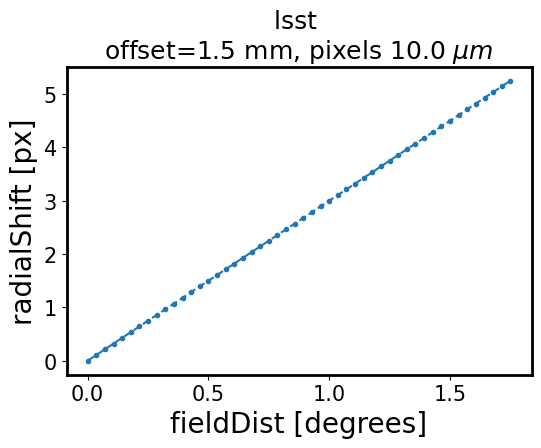

In [4]:
configDir = getConfigDir()
inst = Instrument()

# inside estimateZernikes()
instName='lsst'
camType = getCamType(instName)

# inside wfEsti.config()
opticalModel = 'offAxis'
sizeInPix = 160  # aka donutStamps
inst.configFromFile(sizeInPix, camType)

radialShift = imageCoCenterRadialShiftAtFOV(inst,fov=3.5, plot=True)

## Simulated LSSTCam data - impact of imageCoCenter on wavefront estimation

Run AOS algorithm, using simulated corner sensor data. Turn imageCoCenter stage on and off, and plot if there is any difference in recovered wavefront.

To add the ability to store the value of different calculated quantities (such as the amount of radial shift), I start from  `Algorithm.py` and  `CompensableImage.py` , adding the ability to provide (and update) a dictionary storing the desired information. The structure of `store` dictionary is to preserve for each `iteration-number` the data that is specific for `intra`/`extra` sensors, as well as that which is `common` to both:

    store[iteration_number]['intra'] = {}
    store[iteration_number]['extra'] = {}
    store[iteration_number]['common'] = {}

## Data setup

In [4]:
path_to_project ='/sdf/group/rubin/ncsa-project/project/scichris/aos/'
repo_name  = 'masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/'
repo_dir = os.path.join(path_to_project, repo_name) 
instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'
donutStampsExtra, extraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector="R04_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector="R04_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)
sensor='R04'
extraImage = func.get_butler_image(repo_dir,instrument=instrument,
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)
intraImage = func.get_butler_image(repo_dir,instrument=instrument,
                              iterN=0, detector=f"{sensor}_SW1",
                              collection=collection)

# get the pixel scale from exposure to convert from pixels to arcsec to degrees
pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()
configDir = getConfigDir()
instDir = os.path.join(configDir, "cwfs", "instData")
algoDir = os.path.join(configDir, "cwfs", "algo")

print('Done')

Done


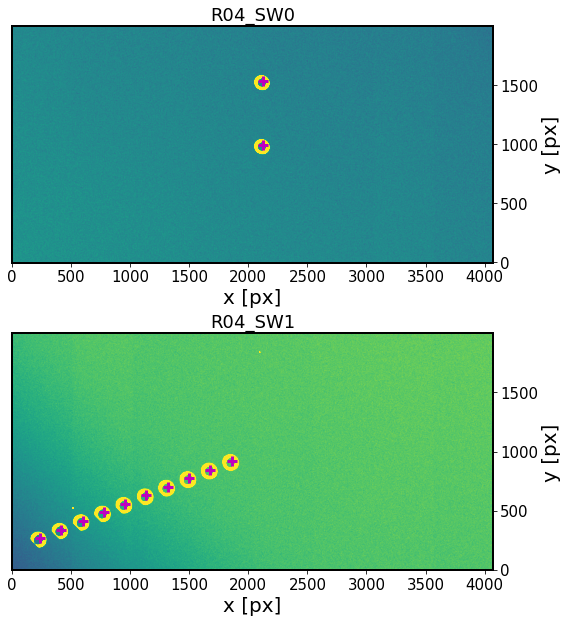

In [6]:
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

fig,ax = plt.subplots(2,1,figsize=(10,10))

row=0
for exposure, srcCat in zip([extraImage, intraImage],
                           [extraFocalCatalog, intraFocalCatalog]):
    data= exposure.image.array
    vmin, vmax = zscale.get_limits(data)

    ax[row].imshow(data, origin='lower', vmin=vmin, vmax=vmax)

    nrows = len(srcCat)
    detectorName = exposure.getDetector().getName()
    
    # mark position of donuts from the donut catalog
    xs = list(srcCat.centroid_x)
    ys = list(srcCat.centroid_y)
    for i in range(nrows):
        x = xs[i] ; y = ys[i]
        ax[row].scatter(x,y,s=100,marker='+',c='m', lw=3)
    ax[row].yaxis.tick_right()
    ax[row].set_xlabel('x [px]')
    ax[row].set_ylabel('y [px]')
    ax[row].yaxis.set_label_position("right")
    ax[row].set_title(f'{detectorName}')
    row+=1
fig.subplots_adjust(hspace=0.3)

## Run the algorithm with and without `imageCoCenter`:

In [18]:
instName='lsst'
opticalModel = 'offAxis'
sizeInPix = 160   # aka donutStamps 
suffix = 'N'
i=1
j=1
   
for doCoCenter in [True,False]:  
 
    # this is part of the init
    inst = Instrument(instDir)
    algo = Algorithm(algoDir)

    # inside estimateZernikes()
    camType = getCamType(instName)
    defocalDisInMm = getDefocalDisInMm(instName)

    # inside wfEsti.config
    inst.config(camType,sizeInPix, announcedDefocalDisInMm=defocalDisInMm)
    
    # choose the solver for the algorithm
    solver = 'exp' # by default
    debugLevel = 1 # 1 to 3
    algo.config(solver, inst, debugLevel=debugLevel)

    centroidFindType = CentroidFindType.RandomWalk
    imgIntra = CompensableImage(centroidFindType=centroidFindType)
    imgExtra = CompensableImage(centroidFindType=centroidFindType)

    # select the only donut pair in that corner
    donutExtra = donutStampsExtra[i]
    donutIntra = donutStampsIntra[j]

    # Inside EstimateZernikesBase
    # Transpose field XY because CompensableImages below are transposed
    # so this gets the correct mask orientation in Algorithm.py
    fieldXYExtra = donutExtra.calcFieldXY()[::-1]
    fieldXYIntra = donutIntra.calcFieldXY()[::-1]

    camera = donutExtra.getCamera() # same camera for both donuts
    detectorExtra = camera.get(donutExtra.detector_name)
    detectorIntra = camera.get(donutIntra.detector_name)


    # Rotate any sensors that are not lined up with the focal plane.
    # Mostly just for the corner wavefront sensors. The negative sign
    # creates the correct rotation based upon closed loop tests
    # with R04 and R40 corner sensors.
    eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
    eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

    # now inside  `wfEsti.setImg` method,
    # which inherits from `CompensableImage`
    imgExtra.setImg(fieldXYExtra,
                    DefocalType.Extra,
                    image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

    imgIntra.setImg(fieldXYIntra,
                    DefocalType.Intra,
                    image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

    boundaryT = algo.getBoundaryThickness()

    # right after we set the image, the compensable image mask is empty -
    # it is only calculated later in Algorithm
    maskScalingFactorLocal = 1

    # rename to just like it is in Algorithm.py
    algo, store = func.runIt_store(algo, imgIntra, imgExtra, model=opticalModel, 
                              tol=1e-3,doCoCenter=doCoCenter)

    # save the values for that donut pair and cocenter
    coCenterText = 'noCocenter'
    if doCoCenter:
        coCenterText = 'doCocenter'

    fname = f'store_extra-{i}_intra-{j}_{coCenterText}_{suffix}.npy'
    fpath = os.path.join(os.getcwd(),fname)
    print(fpath)
    np.save(fpath, store, )

/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/ts_analysis_notebooks/aos/algorithm/store_extra-1_intra-1_doCocenter_N.npy
/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/ts_analysis_notebooks/aos/algorithm/store_extra-1_intra-1_noCocenter_N.npy


Is there any difference?

Diff sum: 0.0


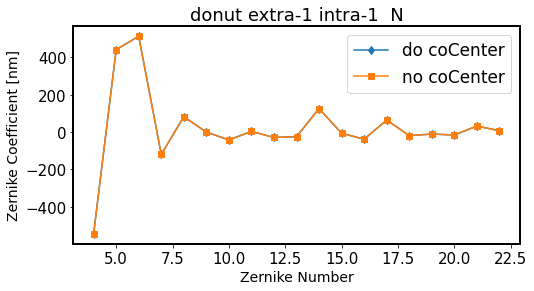

In [20]:
# using auxTel data
i=1
j=1

fname = f'store_extra-{i}_intra-{j}_doCocenter_{suffix}.npy'
fpath = os.path.join(os.getcwd(),fname)
store0 = np.load(fpath, allow_pickle=True).item()

fname = f'store_extra-{i}_intra-{j}_noCocenter_{suffix}.npy'
fpath = os.path.join(os.getcwd(),fname)
store1 = np.load(fpath, allow_pickle=True).item()

fig,ax = plt.subplots(1,1,figsize=(8,4))
zk0 = store0[14]['zer4UpNm']
zk1 = store1[14]['zer4UpNm']

plt.plot(np.arange(4, 23),zk0, '-d', label=f'do coCenter',
            )

plt.plot(np.arange(4, 23),zk1, '-s', label=f'no coCenter',
            )

plt.xlabel('Zernike Number', size=14)
plt.ylabel('Zernike Coefficient [nm]', size=14)
plt.legend(fontsize=17)
plt.title(f'donut extra-{i} intra-{j}  {suffix}')
print('Diff sum:', np.sum(zk0-zk1))

There is absolutely no difference. This is because the amount of shift applied by `coCenter` is :

In [22]:
store0[0]['intra']['cocenter_radialShift']

5.251193404704413

i.e. less than 5.5 pixels radially - that's entirely remedied  at the `recenter` stage during image compensation.

Prove that in the other case absolutely no shift was imparted (because the `imageCoCenter` step was skipped):

In [23]:
np.sum(store1[0]['intra']['imgBeforeCocenter']-store1[0]['intra']['imgAfterCocenter'])

0.0

Indeed - image arrays before and after that step are identical . Consider how much larger the imageCoCenter must be to make a difference:

# Run the same donut pair but scale up the amount of the applied cocenter shift 

First, keep the calculated amount of cocenter, but multiply it by values 1-10 , and check the effect 

Second, run various donuts but increase the offset by much smaller range of factors, eg. from 1.0 to 3.0 in smaller steps 

In [ ]:
i=1 # only one extra-focal donut 
doCoCenter= True 
coCenterText = 'doCocenter'
for increaseFactor in  np.arange(1,3,0.05):
    for j in range(len(donutStampsIntra)): # only one intra-focal donut 
        fname = f'store_extra-{i}_intra-{j}_{coCenterText}_increaseFactor-{increaseFactor}.npy'
        fpath = os.path.join(os.getcwd(),fname)
        if  os.path.exists(fpath):
            print(f'{i} {j} {increaseFactor} {fpath} already exists, skipping')
        else:
            # this is part of the init
            inst = Instrument(instDir)
            algo = Algorithm(algoDir)

            # inside estimateZernikes()
            instName='lsst'
            camType = getCamType(instName)
            defocalDisInMm = getDefocalDisInMm(instName)

            # inside wfEsti.config
            opticalModel = 'offAxis'
            sizeInPix = 160  # aka donutStamps
            inst.config(camType,sizeInPix, announcedDefocalDisInMm=defocalDisInMm)

            # choose the solver for the algorithm
            solver = 'exp' # by default
            debugLevel = 1 # 1 to 3
            algo.config(solver, inst, debugLevel=debugLevel)

            centroidFindType = CentroidFindType.RandomWalk
            imgIntra = CompensableImage(centroidFindType=centroidFindType)
            imgExtra = CompensableImage(centroidFindType=centroidFindType)

            # select the only donut pair in that corner
            donutExtra = donutStampsExtra[i]
            donutIntra = donutStampsIntra[j]

            # Inside EstimateZernikesBase
            # Transpose field XY because CompensableImages below are transposed
            # so this gets the correct mask orientation in Algorithm.py
            fieldXYExtra = donutExtra.calcFieldXY()[::-1]
            fieldXYIntra = donutIntra.calcFieldXY()[::-1]

            camera = donutExtra.getCamera() # same camera for both donuts
            detectorExtra = camera.get(donutExtra.detector_name)
            detectorIntra = camera.get(donutIntra.detector_name)


            # Rotate any sensors that are not lined up with the focal plane.
            # Mostly just for the corner wavefront sensors. The negative sign
            # creates the correct rotation based upon closed loop tests
            # with R04 and R40 corner sensors.
            eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
            eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

            # now inside  `wfEsti.setImg` method,
            # which inherits from `CompensableImage`
            imgExtra.setImg(fieldXYExtra,
                            DefocalType.Extra,
                            image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

            imgIntra.setImg(fieldXYIntra,
                            DefocalType.Intra,
                            image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

            boundaryT = algo.getBoundaryThickness()

            # right after we set the image, the compensable image mask is empty -
            # it is only calculated later in Algorithm
            maskScalingFactorLocal = 1


            # rename to just like it is in Algorithm.py
            algo, store = func.runIt_store(algo, imgIntra, imgExtra, model=opticalModel, 
                                      tol=1e-3,doCoCenter=doCoCenter, increaseFactor=increaseFactor)

            # save the values for that donut pair and cocenter
            coCenterText = 'noCocenter'
            if doCoCenter:
                coCenterText = 'doCocenter'

            print(fpath)
            np.save(fpath, store, )

## Compare retrieved zernikes for these 10 donut pairs (simulated data)
with different amounts of vignetting - does `coCenter` make a noticeable difference?

First, plot all 14 outer loops for a single amount of cocenter to find out what's the progression as zk's are fit:

/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/ts_analysis_notebooks/aos/algorithm/store_extra-1_intra-9_doCocenter_increaseFactor-2.950000000000002.npy


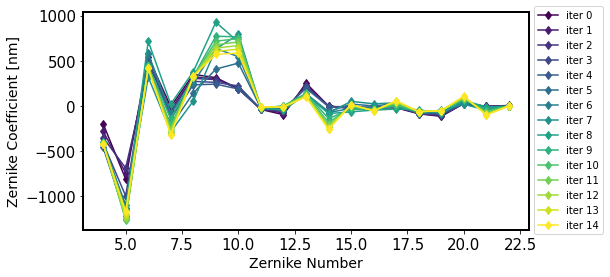

In [28]:
store = np.load(fpath, allow_pickle=True).item()

print(fpath)

fig,ax = plt.subplots(1,1,figsize=(8,4))

nlines = len(store.keys())
color_idx = np.linspace(0, 1, nlines)
ax_legend_handles = []
cmap = plt.cm.viridis

for jj in store.keys():
    color = cmap(color_idx[jj])
    plt.plot(np.arange(4, 23),store[jj]['zer4UpNm'], '-d', label=f'iter {jj}',
            color=color)
    line = mlines.Line2D([], [], color=color, ls='-', marker='o', alpha=1,
                                 )
    ax_legend_handles.append(f'iter {jj} ')
    
plt.xlabel('Zernike Number', size=14)
plt.ylabel('Zernike Coefficient [nm]', size=14)
plt.legend( bbox_to_anchor=[1, 1.05])

This shows us that indeed the fit converges as we go through algorithmic iterations.

## Compare the final zk for each donut pair 

Each donut pair has slightly different baseline offset  because the intra-focal donut is progressively further away from the focal plane:

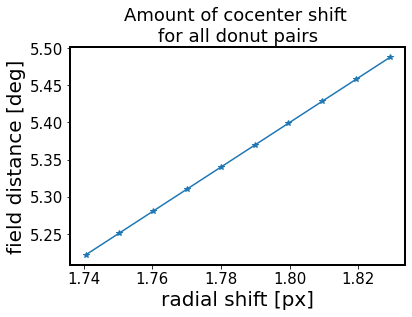

In [73]:
shifts0 = []
fieldDists = []
for j in range(10):
    fname = f'store_extra-{i}_intra-{j}_{coCenterText}_increaseFactor-1.0.npy'
    fpath = os.path.join(os.getcwd(),fname)
    store0 = np.load(fpath, allow_pickle=True).item()
    zk0 = store0[14]['zer4UpNm']
    shift0 = store0[0]['intra']['cocenter_radialShift']
    shifts0.append(shift0)
    
    fieldDists.append(store0[0]['intra']['cocenter_fieldDist'])
plt.title('Amount of cocenter shift \nfor all donut pairs')
plt.xlabel('radial shift [px]')
plt.ylabel('field distance [deg]')
plt.plot(fieldDists, shifts0,'-*')

Show the resulting Zernike coefficients for each donut pair, multiplying the original cocenter radial shift by a factor

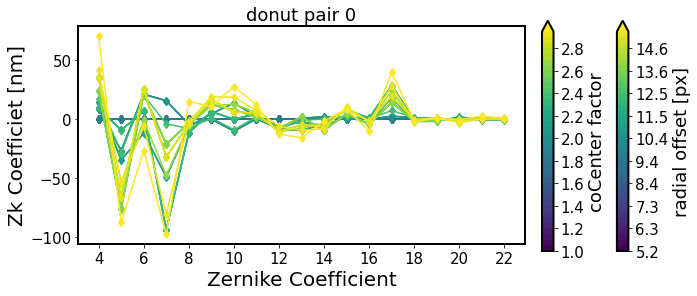

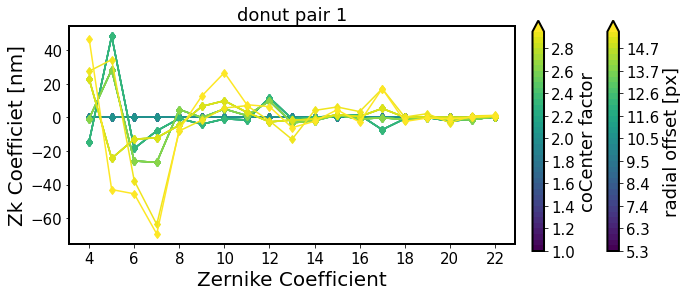

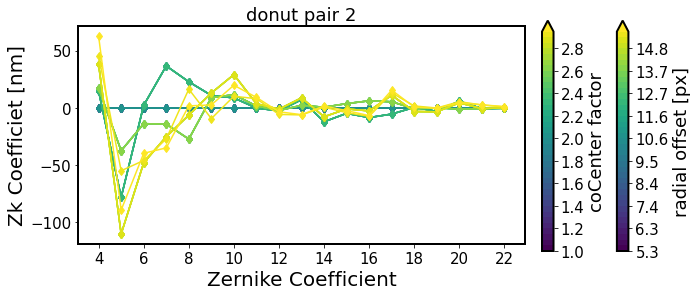

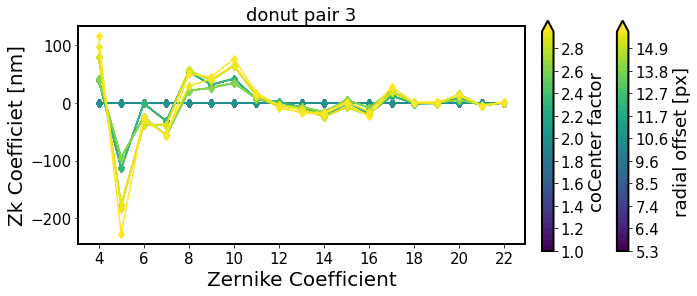

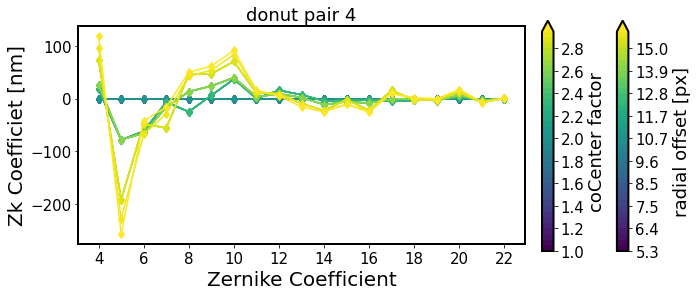

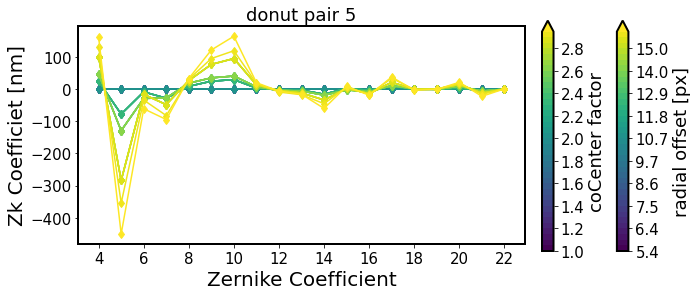

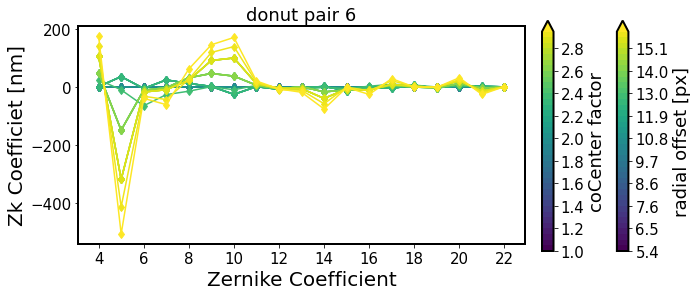

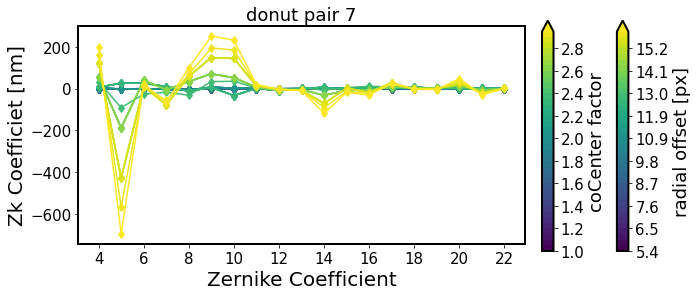

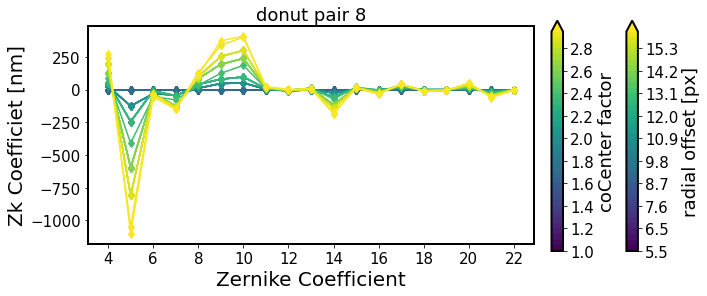

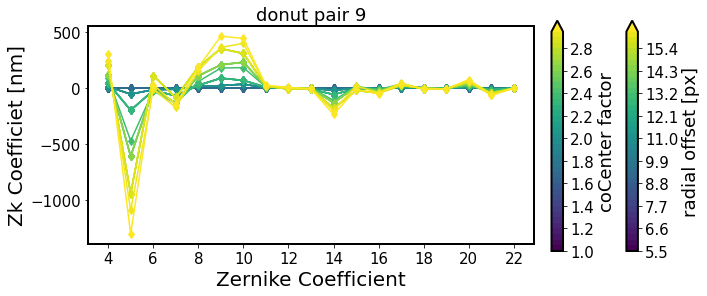

In [74]:
i=1
for j in range(len(donutStampsIntra)): # only one intra-focal donut 

    fig,ax = plt.subplots(1,1,figsize=(8,4))
    coCenterText = 'doCocenter'
    # baseline - multiplying by 1.0 is the same as keeping the original value
    fname = f'store_extra-{i}_intra-{j}_{coCenterText}_increaseFactor-1.0.npy'
    fpath = os.path.join(os.getcwd(),fname)
    store0 = np.load(fpath, allow_pickle=True).item()
    zk0 = store0[14]['zer4UpNm']
    shift0 = store0[0]['intra']['cocenter_radialShift']



    factorSpace = np.arange(1,3,0.05)
    color_idx = np.linspace(0, 1, len(factorSpace))
    ax_legend_handles = []
    jj = 0
    shiftSpace = []
    for increaseFactor in factorSpace:
        color = cmap(color_idx[jj])

        fname = f'store_extra-{i}_intra-{j}_{coCenterText}_increaseFactor-{increaseFactor}.npy'
        fpath = os.path.join(os.getcwd(),fname)
        store = np.load(fpath, allow_pickle=True).item()
        zk = store[14]['zer4UpNm']
        shift = store[0]['intra']['cocenter_radialShift']
        shiftSpace.append(shift)
        ax.plot(np.arange(4, 23), zk-zk0, '-d', 
                label=f'f={increaseFactor}, dr={np.round(shift,2)}',
                color=color)
        line = mlines.Line2D([], [], color=color, ls='-', marker='o', alpha=1,
                                 )
        ax_legend_handles.append(f'f={increaseFactor}')   
        jj += 1 

    ax.set_xlabel('Zernike Coefficient')   
    ax.set_xticks(np.arange(4,24,2))

    ax.set_ylabel('Zk Coefficiet [nm]')


    # add colobar for coCenter 
    bounds = factorSpace
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

    #add_axes([xmin,ymin,dx,dy]) 
    cax = fig.add_axes([0.93,0.1,0.02,0.8
                       ])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        cax=cax, orientation='vertical',
                        format='%.1f'
                       )

    cbar.ax.tick_params(labelsize=15,)
    cbar.set_label(label= "coCenter factor", size=18)    

    # add colorbar with the radial offset ... 
    bounds = shiftSpace
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

    #add_axes([xmin,ymin,dx,dy]) 
    cax = fig.add_axes([1.06,0.1,0.02,0.8
                       ])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        cax=cax, orientation='vertical',
                        format='%.1f'
                       )

    cbar.ax.tick_params(labelsize=15,)
    cbar.set_label(label= "radial offset [px]", size=18)   
    ax.set_title(f'donut pair {j}')

As we see each donut pair is affected by the increase in `coCenter` radial shift. Summarize these changes by calculating the RMS difference between the baseline (`f=1.0`,i.e. using the original coCenter shift) as a function of the increased radial shift.

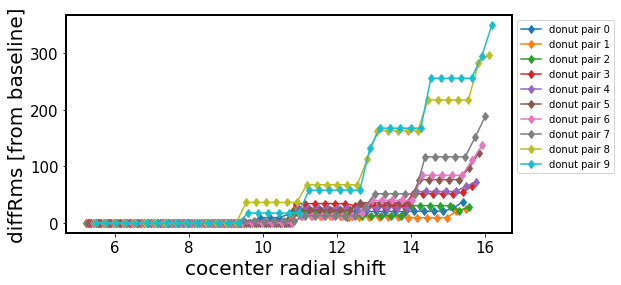

In [75]:
i=1 # use the same extra-focal donut 

fig,ax = plt.subplots(1,1,figsize=(8,4))
coCenterText = 'doCocenter'

# iterate over intra-focal donuts, which increases the distance from the 
# center of the focal plane, i.e. the initial amount of coCenter offset 
for j in range(10):
    
    # baseline
    fname = f'store_extra-{i}_intra-{j}_{coCenterText}_increaseFactor-1.0.npy'
    fpath = os.path.join(os.getcwd(),fname)
    store0 = np.load(fpath, allow_pickle=True).item()
    zk0 = store0[14]['zer4UpNm']
    #shift0 = store0[0]['intra']['cocenter_radialShift']

    diffRms_=[]
    shift_=[]
    factorSpace = np.arange(1,3,0.05)
    
    for increaseFactor in factorSpace:

        fname = f'store_extra-{i}_intra-{j}_{coCenterText}_increaseFactor-{increaseFactor}.npy'
        fpath = os.path.join(os.getcwd(),fname)
        #print(fname)
        store = np.load(fpath, allow_pickle=True).item()
        zk = store[14]['zer4UpNm']
        shift = store[0]['intra']['cocenter_radialShift']
        shift_.append(shift)
        diffRms = np.sqrt(np.sum(np.abs(zk - zk0) ** 2) / len(zk))
        diffRms_.append(diffRms)
        #ax.plot(np.arange(4, 23), zk-zk0, '-d', label=f'f={increaseFactor}, dr={np.round(shift,2)}',
        #            )
    ax.plot(shift_,  diffRms_,'-d' , label=f'donut pair {j}')

    ax.set_xlabel('cocenter radial shift ')
    ax.set_ylabel('diffRms [from baseline]')
ax.legend(bbox_to_anchor=[1, 1.0])

Thus we find that regardless of donut location, the amount of cocenter radial shift needs to exceed **~9 px** to make any difference to the resulting wavefront estimation. Yet, the theoretically maximum amount of radial shift is **~6px** for sources at the edge of the focal plane (radial distance from the center of 3.5 degrees). In conclusion, the future removal of `imageCoCenter` step would **not** affect the value of estimated wavefront Zernike coefficients. 